In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#PDFs in BDT and sindec?
import os

# set env flags to catch BLAS used for scipy/numpy 
# to only use 1 cpu, n_cpus will be totally controlled by csky
os.environ['MKL_NUM_THREADS'] = "1"
os.environ['NUMEXPR_NUM_THREADS'] = "1"
os.environ['OMP_NUM_THREADS'] = "1"
os.environ['OPENBLAS_NUM_THREADS'] = "1"
os.environ['VECLIB_MAXIMUM_THREADS'] = "1"

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['savefig.facecolor'] = 'w'
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import csky as cy
from csky import cext
import numpy as np
import pandas as pd
import astropy
#from icecube import astro
import histlite as hl
import healpy
import pickle
import socket
healpy.disable_warnings()
plt.rc('figure', facecolor = 'w')
plt.rc('figure', dpi=100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define Settings

In [4]:
selection_version = 'version-001-p00'

host_name = socket.gethostname()

if 'cobalt' in host_name:
    print('Working on Cobalts')
    data_prefix = '/data/user/ssclafani/data/cscd/final'
    ana_dir = '/data/user/ssclafani/data/analyses/'
    plot_dir = '/home/mhuennefeld/public_html/analyses/DNNCascade/plots/pdf_construction/test_source_dec_energy_pdf'
    
elif 'phobos' in host_name:
    print('Working on Phobos')
    data_prefix = '/net/big-tank/POOL/users/mhuennefeld/analyses/DNNCascade/data/cscd/final'
    ana_dir = '/net/big-tank/POOL/users/mhuennefeld/analyses/DNNCascade/csky/analyses/'
    plot_dir = '/home/mhuennefeld/analyses/DNNCascade/plots/pdf_construction/test_source_dec_energy_pdf'
    
else:
    raise ValueError('Unknown host:', host_name)

Working on Cobalts


In [5]:
for dir_path in [plot_dir]:
    if not os.path.exists(dir_path):
        print('Creating directory:', dir_path)
        os.makedirs(dir_path)

## Load Data

In [6]:
repo = cy.selections.Repository()
specs = cy.selections.DNNCascadeDataSpecs.DNNC_10yr

In [7]:
%%time

ana = cy.get_analysis(
    repo, selection_version, specs, 
    #gammas=np.r_[0.1:6.01:0.125],
)

Setting up Analysis for:
DNNCascade_10yr
Setting up DNNCascade_10yr...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86

In [8]:
a = ana.anas[0]
a.sig

Events(398873 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent, xdec, xra, true_dec, true_energy, true_ra, oneweight)

In [9]:
a.bg_data

Events(59610 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent)

## Setup Analysis

#### Build PDF

When comparing this to the PDFs used in csky, we can see that the $\sigma$ term is ommitted 
and that some of the conditionals in the energy PDFs changed. 
These changes are valid if a set of assumptions is true:

1. $S(\delta, \alpha| \sigma, E, \gamma, \delta_s, \alpha_s) \approx S(\delta, \alpha| \sigma, \delta_s, \alpha_s)$. This is valid, if $\sigma$ "absorbs" the energy and spectral index conditionals, or in other words, if the coverage of the PSF (von-Mises/Fisher distribution) holds independent of the event energy or spectral index.

2. $\frac{ S(\sigma | E, \gamma, \delta_s)}{B(\sigma | E, \delta)} \approx 1$. If this ratio is approximately one, then we can ommit the sigma terms. Usually the angular uncertainty $\sigma$ is mostly a function of energy. If the dependence on $\delta, \delta_s, \gamma$ is weak, this approximation holds.

3. $S(E | \gamma, \sin{\delta_s}) \approx S(E | \gamma, \sin{\delta})$. For simplicity, we typically build the signal energy PDF conditional on the reconstructed event declination $\delta$ rather than the assumed source declintation $\delta_s$. For event samples with small angular errors such as track, this is mostly a good assumption. If the event is well reconstructed, $\delta_s \approx \delta$ is valid. Events that are further away from the source for which this approximation does not hold, are heavily down-weighted by the spatial signal term. These events for which this assumption does not hold therefore do not contribute much to the overall likelihood. Therefore, this is usually a good enough approximation, but it may cause issues for event samples with large angular uncertainties such as cascades.

Here we will test if fixing assumption 3. will help mitigate bias seen in the PS analysis.
We will need to construct the PDF ratio:

$S(E | \gamma, \sin{\delta_s}) / B(E | \sin{\delta})$

In [10]:
from csky import models
from csky.models.grid import EquidistantGridLinearInterpPDF

def reweight(ow, energy, gamma, norm=1.0e-18, 
             e_pivot=1e5, energy_cutoff=None):
    """Reweight events according to power_law
    """
    n_types = 2.  # Dividing by n_types gives flux per flavor and per type
    weight = ow * norm * np.power(energy/e_pivot, -gamma) / n_types
    
    if energy_cutoff is not None:
        weight *= np.exp(-energy / energy_cutoff)
    return weight


##### Signal PDF $S(E | \gamma, \sin{\delta_s})$

In [36]:
init_kwargs = {
    'observables': ['log10energy'],
    'conditionals': ['src->sindec', 'gamma'],

    'grid_spec': {
        'log10energy': (float(np.log10(400)), 8.1, 15), 
        'gamma': (1., 4., 50),
        'src->sindec': (-1., 1., 15),
    },
    'min_grid_prob': 1e-7,
    'dtype': 'float64',
    'minimizer_options': {
        'method': 'L-BFGS-B',
        'options': dict(iprint=1, gtol=1e-7),
    },
}
grid_model_sig = EquidistantGridLinearInterpPDF(**init_kwargs)
grid_model_sig.build_pdf(
    df=a.sig,
    weights=None, #weights, # needs to be None if conditional on gamma
)

Building PDF ...
  Oversampling 101x for Gamma
  Initializing Grid ...
    Initial Loss 1.5561705798389706e-05
  Starting Minimization ...
  Finished Minimization after: 22.765s
    Final Loss 1.4885821577187298e-05
  Done!


##### Background PDF $B(E | \sin \delta)$

In [37]:
init_kwargs = {
    'observables': ['log10energy'],
    'conditionals': ['sindec'],

    'grid_spec': {
        'log10energy': (float(np.log10(400)), 8.1, 15), 
        'sindec': (-1., 1., 15),
    },
    #'gamma_oversampling': 100,
    'min_grid_prob': 1e-7,
    'dtype': 'float64',
    'minimizer_options': {
        'method': 'L-BFGS-B',
        'options': dict(iprint=1, gtol=1e-6),
    },
}
grid_model_bkg = EquidistantGridLinearInterpPDF(**init_kwargs)
grid_model_bkg.build_pdf(df=a.bg_data)


Building PDF ...
  Initializing Grid ...
    Initial Loss 0.2198992604877053
  Starting Minimization ...
  Finished Minimization after: 1.530s
    Final Loss 0.21679533787871466
  Done!


##### Ratio Model

In [38]:
ratio_model_grid = models.PDFRatioWrapper(
    m_signal=grid_model_sig,
    m_bkg=grid_model_bkg,
    #update_method='p_sig',
    #update_method='p_inj',
    #inj_grid_spec=grid_model_bkg.grid_spec,
)

print('features:', ratio_model_grid.features)
print('parameters:', ratio_model_grid.parameters)
print('observables:', ratio_model_grid.observables)
print('conditionals:', ratio_model_grid.conditionals)
print('update_method:', ratio_model_grid.update_method)


features: {'log10energy': 'log10energy', 'sindec': 'sindec'}
parameters: ['gamma', 'log10energy', 'sindec', 'src->sindec']
observables: ['log10energy']
conditionals: ['gamma', 'sindec', 'src->sindec']
update_method: update


#### Construct Trial Runners

In [48]:
sindec_randomization_width = 5 #3

def get_trial_runner(sindec, gamma, cpus, ra=0., cutoff_TeV=np.inf, sigsub=True):
    src = cy.utils.sources(ra, np.arcsin(sindec), deg=False)
    cutoff_GeV = cutoff_TeV * 1e3
    conf = {
        'src' : src, 
        'flux' : cy.hyp.PowerLawFlux(gamma, energy_cutoff = cutoff_GeV),
        'update_bg': True,
        'sigsub' :  sigsub,
        'randomize' : ['ra', cy.inj.DecRandomizer],
        'sindec_bandwidth' : np.radians(5),
        'dec_rand_method' : 'gaussian_fixed',
        'dec_rand_kwargs' : dict(randomization_width = np.radians(sindec_randomization_width)), # 3
        'dec_rand_pole_exlusion' : np.radians(8)
    }
    tr = cy.get_trial_runner(ana=ana, conf= conf, mp_cpus=cpus)
    return tr, src

def get_trial_runner_grid(sindec, gamma, cpus, ratio_model=ratio_model_grid, ra=0., cutoff_TeV=np.inf, sigsub=True):
    src = cy.utils.sources(ra, np.arcsin(sindec), deg=False)
    cutoff_GeV = cutoff_TeV * 1e3
    conf = {
        'src' : src, 
        'flux' : cy.hyp.PowerLawFlux(gamma, energy_cutoff = cutoff_GeV),
        'update_bg': True,
        'sigsub' :  sigsub,
        'randomize' : ['ra', cy.inj.DecRandomizer],
        'sindec_bandwidth' : np.radians(5),
        'dec_rand_method' : 'gaussian_fixed',
        'dec_rand_kwargs' : dict(randomization_width = np.radians(sindec_randomization_width)),
        'dec_rand_pole_exlusion' : np.radians(8),
        
        # Modifications for custom energy ratio PDF
        cy.pdf.GenericPDFRatioModel: dict(
            func = ratio_model,
            features = ratio_model.features,
            fits = dict(gamma=np.r_[1, 1:4.01:.125, 4]),
        ),
        'energy': False,
    }
    tr = cy.get_trial_runner(ana=ana, conf= conf, mp_cpus=cpus)
    return tr, src

def get_bias_allt(tr, ntrials=200, n_sigs=np.r_[:101:10], quiet=False):
    trials = [
        (None if quiet else print(f'\r{n_sig:4d} ...', end='', flush=True))
        or
        tr.get_many_fits(ntrials, n_sig=n_sig, logging=False, seed=n_sig)
        for n_sig in n_sigs]
    if not quiet:
        print()
    for (n_sig, t) in zip(n_sigs, trials):
        t['ntrue'] = np.repeat(n_sig, len(t))
    allt = cy.utils.Arrays.concatenate(trials)
    return allt


## Plotting Helpers

In [49]:

def plot_ns_bias(ax, tr, allt, label=''):

    n_sigs = np.unique(allt.ntrue)
    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)

    h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, 
              drawstyle='default', label=label)
    lim = ns_bins[[0, -1]]
    ax.set_xlim(ax.set_ylim(lim))
    ax.plot(lim, lim, **expect_kw)
    ax.set_aspect('equal')

    ax.set_xlabel(r'$n_{inj}$')
    ax.set_ylabel(r'$n_s$')
    ax.grid()

def plot_gamma_bias(ax, tr, allt, label=''):

    n_sigs = np.unique(allt.ntrue)
    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)
    expect_gamma = tr.sig_injs[0].flux[0].gamma

    h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, 
              drawstyle='default', label=label)
    lim = ns_bins[[0, -1]]
    ax.set_xlim(lim)
    ax.set_ylim(1, 4)
    ax.axhline(expect_gamma, **expect_kw)

    ax.set_xlabel(r'$n_{inj}$')
    ax.set_ylabel(r'$\gamma$')
    ax.grid()


## Test Bias

sindec = -0.6 | gamma = 2 ...
 224 ...
CPU times: user 716 ms, sys: 21.1 s, total: 21.9 s
Wall time: 1min 5s


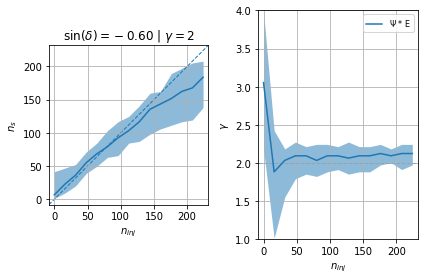

In [47]:
%%time
%matplotlib inline

mp_cpus = 20
fit_gamma = True

runners_to_check = [
    #(get_trial_runner_grid, f'$\Psi$ * E [src-dec]'),
    (get_trial_runner, f'$\Psi$ * E'),
]

#for tr_gamma in [2., 2.5, 3.]:
for tr_gamma in [2]:
    #for sindec in np.linspace(-0.99, 0.99, 20):
    #for sindec in [ 0, .4]:
    #for sindec in [-.95]:
    #for sindec in [-.8, -.4, 0, .4, .8]:
    #for sindec in [-.95, -.8, -.6, -.4, -.2, 0, .2, .4, .6, .8, .95]:
    for sindec in [-0.6]:
        print(f'sindec = {sindec} | gamma = {tr_gamma} ...')
        
        if fit_gamma:
            fig, axes = plt.subplots(1, 2)
        else:
            fig, ax = plt.subplots(1, 1)
        for trial_run_func, label in runners_to_check:
            trial_runner, src = trial_run_func(
                sindec, gamma=tr_gamma, cpus=mp_cpus)
            allt_i = get_bias_allt(
                trial_runner, ntrials=50, n_sigs=np.r_[:int(120*tr_gamma):int(8*tr_gamma)])
            if fit_gamma:
                plot_ns_bias(axes[0], trial_runner, allt_i, label=label)
                plot_gamma_bias(axes[1], trial_runner, allt_i, label=label)
            else:
                plot_ns_bias(ax, trial_runner, allt_i, label=label)
        if fit_gamma:
            axes[0].set(title=rf'$\sin(\delta)={sindec:+.2f}$ | $\gamma={tr_gamma}$')
            axes[1].legend(fontsize=8)
        else:
            ax.set(title=rf'$\sin(\delta)={sindec:+.2f}$ | fixed $\gamma={tr_gamma}$')
            ax.legend(fontsize=8)
        fig.tight_layout()
        fig.savefig('{}/bias_sindec{:2.2f}_gamma{:2.2f}.png'.format(
            plot_dir, sindec, tr_gamma))
